In [123]:
#import the libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [124]:
#defining start and end rows in my dataset to reduce the energy processing took up as it often resulted in error
start_row = 20600
end_row = 206600
desired_start_siteid = 51
#importing my datasets
#using a delimiter to match read_csv so it comes out as separate columns instead of a single string
consumption_data = pd.read_csv('power-laws-forecasting-energy-consumption-test-data.csv', sep=';', skiprows=range(20600, start_row), nrows=end_row - start_row)
#filtering and sorting the data so it will output properly
filtered_data = consumption_data[consumption_data['SiteId'] >= desired_start_siteid]
sorted_data = filtered_data.sort_values(by='SiteId', ascending=True)
sorted_data.head()

,obs_id,SiteId,Timestamp,ForecastId,Value
7539,4498843,51,2015-12-22T00:00:00+00:00,1275,16373.182909
7543,4135747,51,2015-12-24T01:00:00+00:00,1275,16161.761841
7542,6046033,51,2015-12-22T08:00:00+00:00,1275,269157.404420
7541,6114413,51,2015-12-22T07:00:00+00:00,1275,127554.313817
7540,2923733,51,2015-12-22T04:00:00+00:00,1275,16449.171930


In [125]:
start_row = 206413
end_row = 206600
consumption_data2 = pd.read_csv('power-laws-forecasting-energy-consumption-training-data.csv', sep=';', skiprows=range(1, start_row), nrows=end_row - start_row)
consumption_data2.head()

,obs_id,SiteId,Timestamp,ForecastId,Value
0,6003613,123,2016-06-18T17:30:00+00:00,2782,8438.412854
1,4776511,123,2016-06-19T04:15:00+00:00,2782,124.322841
2,173273,123,2016-06-19T17:00:00+00:00,2782,8536.835104
3,2770283,123,2016-06-19T23:00:00+00:00,2782,122.596135
4,4405265,123,2016-06-19T23:45:00+00:00,2782,124.322841


In [126]:
building_metadata = pd.read_csv('power-laws-forecasting-energy-consumption-metadata.csv', sep=';')

building_metadata.head()

,SiteId,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff
0,207,7964.873347,30.0,18.0,False,False,False,False,False,True,True
1,7,15168.125971,30.0,18.0,False,False,False,False,False,True,True
2,74,424.340663,15.0,18.0,False,False,False,False,False,True,True
3,239,1164.822636,15.0,18.0,False,False,False,False,False,True,True
4,274,1468.246690,5.0,18.0,False,False,False,False,False,True,True


In [127]:
#pd.unique(weather_data.SiteId)

In [128]:
#defining the number of rows that the system reads
nRowsRead = 1000

weather_data = pd.read_csv('power-laws-forecasting-energy-consumption-weather.csv', sep=';', nrows=nRowsRead)

weather_data.head()

,Timestamp,Temperature,Distance,SiteId
0,2017-03-03T19:00:00+00:00,10.6,27.489346,51
1,2017-03-03T19:20:00+00:00,11.0,28.663082,51
2,2017-03-03T20:00:00+00:00,6.3,28.307039,51
3,2017-03-03T21:55:00+00:00,10.0,29.797449,51
4,2017-03-03T23:00:00+00:00,5.4,28.307039,51


In [129]:
holidays_data = pd.read_csv('power-laws-forecasting-energy-consumption-holidays.csv', sep=';')

holidays_data.head()

,Date,Holiday,SiteId
0,2016-02-15,Washington's Birthday,1
1,2017-05-29,Memorial Day,1
2,2017-11-23,Thanksgiving Day,1
3,2017-12-29,New Years Eve Shift,1
4,2017-12-31,New Years Eve,1


In [133]:
#checking the shape to ensure data was imported properly
holidays_data.shape

(8387, 3)

In [134]:
weather_data.shape

(1000, 4)

In [135]:
consumption_data.shape

(186000, 5)

In [136]:
building_metadata.shape

(267, 11)

In [138]:
#coverting to datetime format
pd.to_datetime(weather_data.Timestamp).head()

0   2017-03-03 19:00:00+00:00
1   2017-03-03 19:20:00+00:00
2   2017-03-03 20:00:00+00:00
3   2017-03-03 21:55:00+00:00
4   2017-03-03 23:00:00+00:00
Name: Timestamp, dtype: datetime64[ns, UTC]

In [139]:
pd.to_datetime(holidays_data.Date).head()

0   2016-02-15
1   2017-05-29
2   2017-11-23
3   2017-12-29
4   2017-12-31
Name: Date, dtype: datetime64[ns]

In [140]:
#merging data from all the datasets onto the SiteId
merged_data = pd.merge(building_metadata, weather_data, on='SiteId')
#merged_data = pd.merge(merged_data, holidays_data, on='SiteId')

#merged_data = pd.merge(consumption_data, weather_data, on='SiteId')

merged_data = pd.merge(merged_data, consumption_data, on='SiteId')

merged_data.head()

,SiteId,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff,Timestamp_x,Temperature,Distance,obs_id,Timestamp_y,ForecastId,Value
0,51,7142.355221,15.0,18.0,False,False,False,False,False,True,True,2017-03-03T19:00:00+00:00,10.6,27.489346,760593,2015-12-20T02:00:00+00:00,1275,16556.414501
1,51,7142.355221,15.0,18.0,False,False,False,False,False,True,True,2017-03-03T19:00:00+00:00,10.6,27.489346,6713825,2015-12-20T13:00:00+00:00,1275,7429.765311
2,51,7142.355221,15.0,18.0,False,False,False,False,False,True,True,2017-03-03T19:00:00+00:00,10.6,27.489346,6872139,2015-12-20T20:00:00+00:00,1275,11896.571593
3,51,7142.355221,15.0,18.0,False,False,False,False,False,True,True,2017-03-03T19:00:00+00:00,10.6,27.489346,6704637,2015-12-21T06:00:00+00:00,1275,31426.975788
4,51,7142.355221,15.0,18.0,False,False,False,False,False,True,True,2017-03-03T19:00:00+00:00,10.6,27.489346,7550461,2015-12-21T11:00:00+00:00,1275,279955.199272


In [143]:
#merged_data['Distance'].isnull().sum()

In [145]:
# print('Holiday' in holidays_data.columns)

# print('Holiday_SiteId' in merged_data.columns)

In [146]:
#utilizing lag for my time series data to take into account historical values of the energy data
#creates a new column inside the loop
#shifts values downward by n positions 

lags = range(1, 7)  
#creating range of integers to represent the numnber time periods the data will be shifted
for lag in lags:
    merged_data[f'Lag_{lag}'] = merged_data.groupby('SiteId')['Value'].shift(lag)
#making the lagged integers be from the siteid and value columns

In [150]:
#taking 80% of the data to put in the training set 
train_size = int(len(merged_data) * 0.8)
#creating the test data by slicing to divide the merged data to help assess how well the model generalizes
train_data, test_data = merged_data[:train_size], merged_data[train_size:]

In [153]:
#train_data = train_data[~y_train.isnull()]
#test_data = test_data[~y_test.isnull()]

In [155]:
#model = HistGradientBoostingRegressor()

In [156]:
# #input features for RFR to predict the target variable incl. lagged inputs
features = ['Temperature', 'Surface', 'Sampling', 'BaseTemperature'] + [f'Lag_{lag}' for lag in lags]
#splitting into train and test datasets
X_train, y_train = train_data[features], train_data['Value']
X_test, y_test = test_data[features], test_data['Value']

In [158]:
#print(len(merged_data.columns))

#unique_columns = set()

#list to store duplicate column names
#duplicate_columns = []

#iterate through columns
#for column in merged_data.columns:
    #if the column name is not in the set, add it to the set
    #if it's already in the set, add it to the duplicate_columns list
    #if column not in unique_columns:
        #unique_columns.add(column)
    #else:
        #duplicate_columns.append(column)

#drop the duplicate columns from the DataFrame
#merged_data = merged_data.drop(columns=duplicate_columns)

In [160]:
#checking for the missing values in X_train before running my model
if X_train.empty:
    print("X_train is empty.")
else:
    missing_values = X_train.isnull().sum()
    if missing_values.sum() == 0:
        print("X_train does not contain missing values.")
    else:
        print("X_train contains missing values.")
        print("Missing value counts by column:")
        print(missing_values)

#check the shape of X_train
print("Shape of X_train:", X_train.shape)

X_train.head()

X_train contains missing values.
Missing value counts by column:
Temperature        0
Surface            0
Sampling           0
BaseTemperature    0
Lag_1              1
Lag_2              2
Lag_3              3
Lag_4              4
Lag_5              5
Lag_6              6
dtype: int64
Shape of X_train: (25600, 10)


,Temperature,Surface,Sampling,BaseTemperature,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6
0,10.6,7142.355221,15.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
1,10.6,7142.355221,15.0,18.0,16556.414501,NaN,NaN,NaN,NaN,NaN
2,10.6,7142.355221,15.0,18.0,7429.765311,16556.414501,NaN,NaN,NaN,NaN
3,10.6,7142.355221,15.0,18.0,11896.571593,7429.765311,16556.414501,NaN,NaN,NaN
4,10.6,7142.355221,15.0,18.0,31426.975788,11896.571593,7429.765311,16556.414501,NaN,NaN


In [161]:
#filling missing values using the imputer and utilzing median for the outliers
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [165]:
#using RFR for regression
#setting the seed to 42 so it is reproducible
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [166]:
#fitting the model to the training data
print(X_train)
model.fit(X_train, y_train)

[[1.06000000e+01 7.14235522e+03 1.50000000e+01 ... 1.63731829e+04
  1.63731829e+04 1.63731829e+04]
 [1.06000000e+01 7.14235522e+03 1.50000000e+01 ... 1.63731829e+04
  1.63731829e+04 1.63731829e+04]
 [1.06000000e+01 7.14235522e+03 1.50000000e+01 ... 1.63731829e+04
  1.63731829e+04 1.63731829e+04]
 ...
 [2.30000000e+01 7.14235522e+03 1.50000000e+01 ... 2.38568759e+04
  2.87484853e+05 2.83630862e+05]
 [2.30000000e+01 7.14235522e+03 1.50000000e+01 ... 1.12843697e+04
  2.38568759e+04 2.87484853e+05]
 [2.30000000e+01 7.14235522e+03 1.50000000e+01 ... 1.06507193e+04
  1.12843697e+04 2.38568759e+04]]


RandomForestRegressor(random_state=42)

In [167]:
#making predictions on the test data
y_pred = model.predict(X_test)

In [168]:
#calculation the mean squared error
#based on this score, we can see that the difference between acual and predicted values that it is very close to the actual valyes
mse = mean_squared_error(y_test, y_pred)
print(mse)

6.057569176233171e-19


In [169]:
#calculation the root mean squared error
#average deviation is very low
rmse = np.sqrt(mse)
print(rmse)

7.783038722910975e-10


In [170]:
#calculating the mean absolute error
#absolute difference is very low - less sensitive to outliers
mae = mean_absolute_error(y_test, y_pred)
print(mae)

3.2669305483068455e-10


<Axes: xlabel='Temperature', ylabel='Count'>

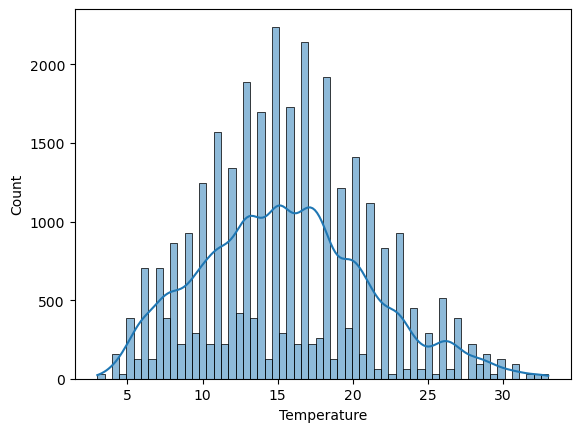

In [172]:
sns.histplot(data=merged_data, x='Temperature', kde=True)
#using a histplot to see the line between actual and predicted with the temperature value - seems to show a very close fit

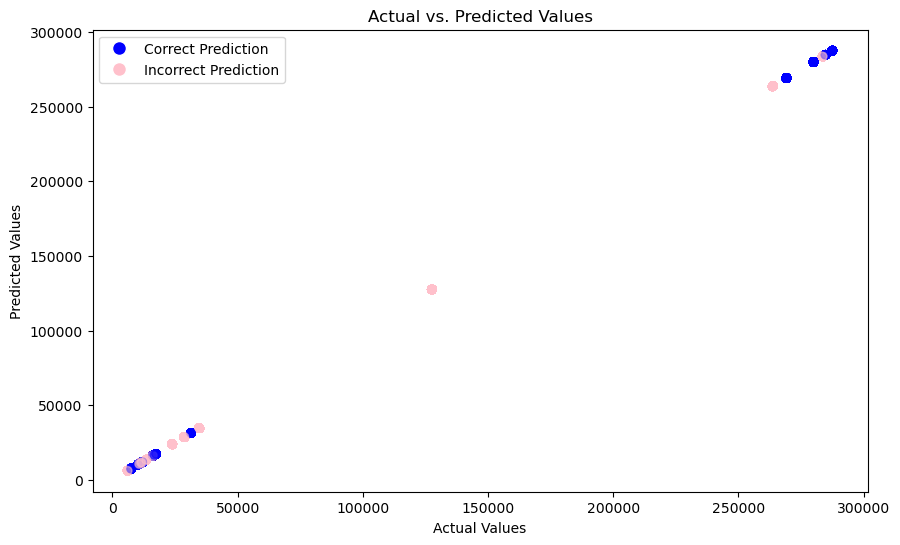

In [173]:
colors = ['pink' if pred >= actual else 'blue' for actual, pred in zip(y_test, y_pred)]

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c=colors, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')

plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Correct Prediction', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Incorrect Prediction', markerfacecolor='pink', markersize=10)
])

plt.show()
#using a scatterplot and changing the colors to more clearly see the actual v predicted values
#based off this, I am a little off on the machine learning's predictions but is seems very close

Project Conclusion

In this project, I analyzed energy consumption data and built a machine learning model to make predictions. Here are the key takeaways:

Data Analysis Insights:

I explored various datasets including energy consumption, weather, and metadata.

Lagged features were introduced to account for historical patterns in energy consumption.

Data quality checks, such as identifying missing values and column presence, were conducted to ensure data integrity.

Machine Learning Model Performance:

I used a Random Forest Regressor which is a machine learning algorithm to make energy consumption predictions.

The metrics I used to analyze this algorithm  like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE) indicated minimal prediction errors leading me to trust the model's accuracy.

Real-World Applications:

My machine learning model has the potential for real-world applications in energy consumption forecasting. Its precision and ability to capture historical patterns make it a valuable tool for energy management and optimization.

Industries and organizations that rely on energy resources, such as power plants, commercial buildings, and smart grids, can benefit from accurate energy consumption predictions.

By optimizing energy usage based on accurate forecasts, businesses can reduce costs, minimize waste, and contribute to sustainability efforts.

In conclusion, this project highlights the power of data analysis and machine learning in addressing real-world challenges. There were a lot of ups and downs in creating this model but, in the end, I gained incredible insights from my analysis and process and believe that the model's performance adds to the potential for improved energy management and efficiency in various sectors. As I continue to refine and validate my model in the future, its practical applications in optimizing energy resources will become increasingly promising.